In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from forex_python.converter import CurrencyRates
from pypfopt import EfficientFrontier
import math

In [4]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [5]:
stock_prices = pd.DataFrame()
stock_returns = pd.DataFrame()

today_date = datetime.now()
end = today_date.strftime('%Y-%m-%d')

for x in portfolio:
    stock = yf.Ticker(x)
    close_price = stock.history(start='2021-01-01', end=end)['Close']

    stock_prices = pd.concat([stock_prices, close_price], axis=1)

    stock_returns = pd.concat([stock_returns, close_price.pct_change()], axis=1)

stock_prices.columns = portfolio
stock_returns.columns = portfolio

stock_prices = stock_prices.dropna()
stock_returns = stock_returns.dropna()

In [6]:
# Descargar el histórico del dólar (USD a COP)
usd_cop = yf.Ticker("COP=X").history(start='2021-01-01', end=end)['Close']

# Asegurar que los índices coincidan con tus stock_prices
usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')

In [7]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

# Aplicar la conversión solo a esas columnas
for ticker in stocks_en_usd:
    if ticker in stock_prices.columns:
        stock_prices[ticker] = stock_prices[ticker] * usd_cop

In [8]:
stock_prices.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-04 00:00:00-05:00,1157.895508,1699.219360,21898.806641,22459.767578,292976.174648,430864.135826,7506.622559,446224.104069,1.179055e+06
2021-01-05 00:00:00-05:00,1183.718384,1715.099731,21905.246094,23914.630859,297713.443977,439698.339787,7557.256836,453439.835197,1.196401e+06
2021-01-06 00:00:00-05:00,1191.981689,1708.747559,22001.888672,22862.037109,294305.468019,424219.599861,7557.256836,456306.700054,1.201704e+06
2021-01-07 00:00:00-05:00,1225.551392,1626.804199,22240.269531,23002.830078,300502.861099,434942.192136,7772.455566,460665.776733,1.209060e+06
2021-01-08 00:00:00-05:00,1238.979248,1628.074219,22401.337891,23532.476562,311211.727713,448393.674105,8038.288574,475396.556312,1.242834e+06


Text(0.5, 1.0, 'Stock Prices Over Time')

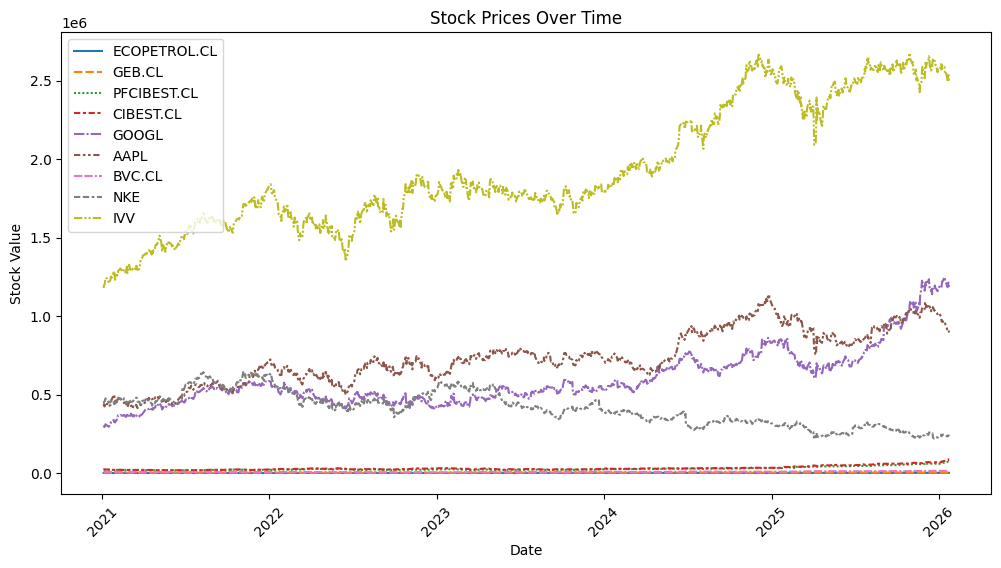

In [9]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_prices)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Stock Prices Over Time')



Text(0.5, 1.0, 'Stock Returns Over Time')

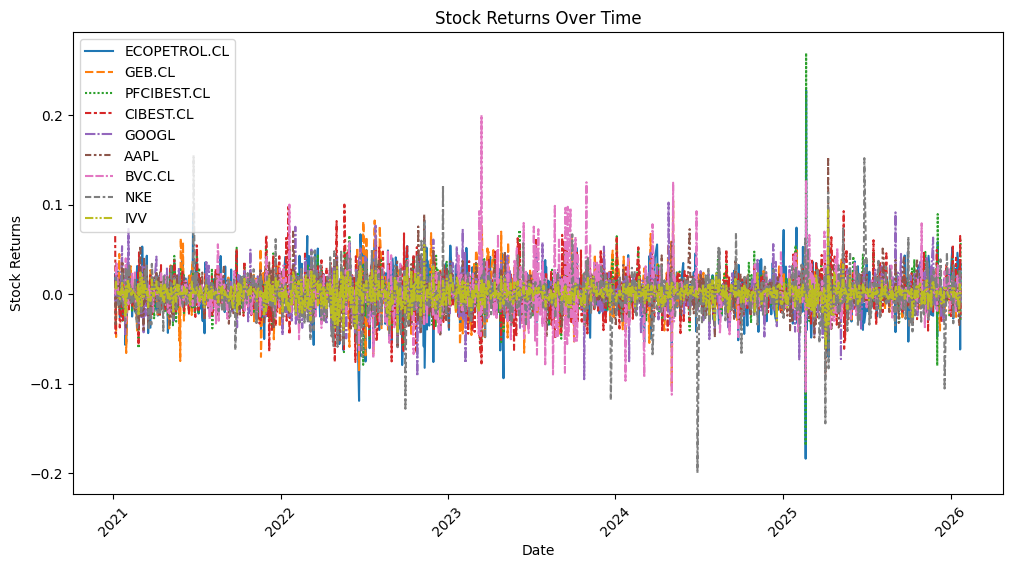

In [10]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_returns)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')

In [11]:
expected_stock_returns = []
individual_stock_risk = []

for x, y in stock_returns.items():
    expected_stock_returns.append(y.mean())

    individual_stock_risk.append(y.std())

In [12]:
print(f"Mean return (percent)")

for name, value in zip(portfolio, expected_stock_returns):
    print(f"\t{name}: \t{value}%")

Mean return (percent)
	ECOPETROL.CL: 	0.0007673983822001681%
	GEB.CL: 	0.0006217253579867619%
	PFCIBEST.CL: 	0.0012784070493822956%
	CIBEST.CL: 	0.0014026494197572458%
	GOOGL: 	0.0010967954255757762%
	AAPL: 	0.0005068254815194664%
	BVC.CL: 	0.0008269764744859875%
	NKE: 	-0.0003592025103749136%
	IVV: 	0.0004884334878784392%


In [13]:
print(f"Risk (Std. Dev)")

for name, value in zip(portfolio, individual_stock_risk):
    print(f"\t{name}: \t{value}")

Risk (Std. Dev)
	ECOPETROL.CL: 	0.023318843341161643
	GEB.CL: 	0.01912403139502936
	PFCIBEST.CL: 	0.019935583205310806
	CIBEST.CL: 	0.021634041427082668
	GOOGL: 	0.019771480107199847
	AAPL: 	0.017708495663474946
	BVC.CL: 	0.02154604258657167
	NKE: 	0.02213206665775128
	IVV: 	0.01081013842960972


In [14]:
expected_stock_returns = np.array(pd.DataFrame(expected_stock_returns))
individual_stock_risk = np.array(pd.DataFrame(individual_stock_risk))

stock_returns_cov_matrix = np.array(stock_returns.cov())

In [15]:
stock_returns_cov_matrix

array([[ 5.43768455e-04,  1.11315911e-04,  2.28505210e-04,
         1.10646946e-04,  5.17875860e-05,  6.51318366e-05,
         7.94134246e-05,  8.35103242e-05,  5.77237494e-05],
       [ 1.11315911e-04,  3.65728577e-04,  7.68721573e-05,
         5.35670421e-05,  2.97005964e-05,  1.96414482e-05,
         6.85054925e-05,  3.87881750e-05,  2.98031463e-05],
       [ 2.28505210e-04,  7.68721573e-05,  3.97427478e-04,
         2.23820160e-04,  5.05218399e-05,  5.78917073e-05,
         8.12279048e-05,  7.14226262e-05,  5.14893482e-05],
       [ 1.10646946e-04,  5.35670421e-05,  2.23820160e-04,
         4.68031748e-04,  3.20834297e-05,  2.47688433e-05,
        -1.22813035e-05,  4.09708491e-05,  3.20582106e-05],
       [ 5.17875860e-05,  2.97005964e-05,  5.05218399e-05,
         3.20834297e-05,  3.90911426e-04,  2.05850912e-04,
         3.17303089e-05,  1.59679231e-04,  1.47888807e-04],
       [ 6.51318366e-05,  1.96414482e-05,  5.78917073e-05,
         2.47688433e-05,  2.05850912e-04,  3.135908

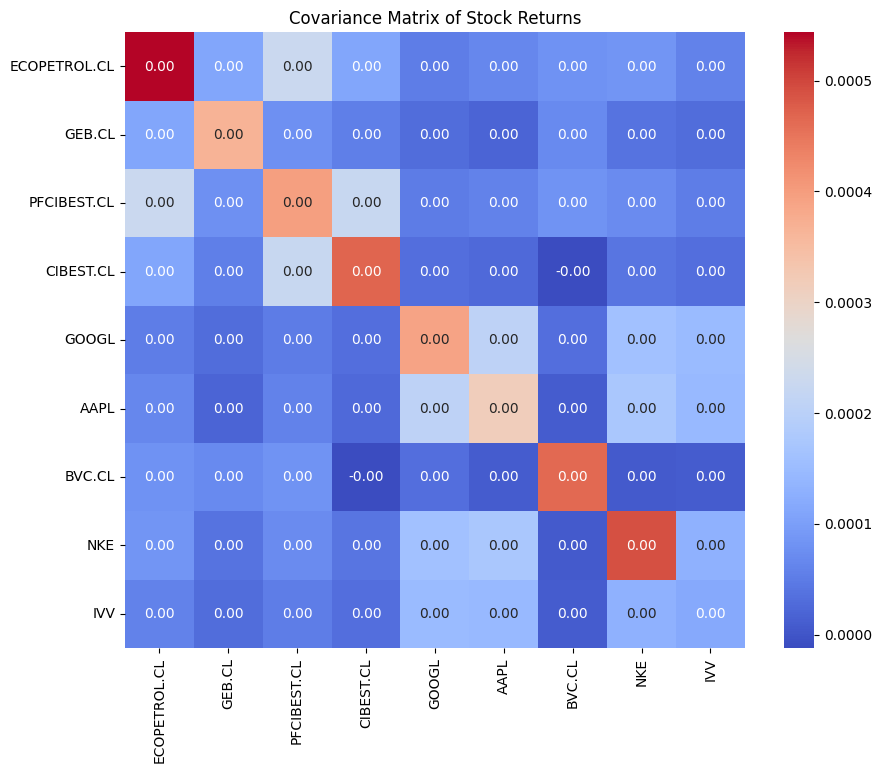

In [16]:
cov_matrix_df = stock_returns.cov()

plt.figure(figsize=(10,8))

sns.heatmap(cov_matrix_df, annot=True, fmt=".2f", cmap='coolwarm')

plt.title('Covariance Matrix of Stock Returns')

plt.show()

In [17]:
cov_matrix_df

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
ECOPETROL.CL,0.000544,0.000111,0.000229,0.000111,0.000052,0.000065,0.000079,0.000084,0.000058
GEB.CL,0.000111,0.000366,0.000077,0.000054,0.000030,0.000020,0.000069,0.000039,0.000030
PFCIBEST.CL,0.000229,0.000077,0.000397,0.000224,0.000051,0.000058,0.000081,0.000071,0.000051
CIBEST.CL,0.000111,0.000054,0.000224,0.000468,0.000032,0.000025,-0.000012,0.000041,0.000032
GOOGL,0.000052,0.000030,0.000051,0.000032,0.000391,0.000206,0.000032,0.000160,0.000148
AAPL,0.000065,0.000020,0.000058,0.000025,0.000206,0.000314,0.000008,0.000174,0.000146
BVC.CL,0.000079,0.000069,0.000081,-0.000012,0.000032,0.000008,0.000464,0.000007,0.000008
NKE,0.000084,0.000039,0.000071,0.000041,0.000160,0.000174,0.000007,0.000490,0.000130
IVV,0.000058,0.000030,0.000051,0.000032,0.000148,0.000146,0.000008,0.000130,0.000117


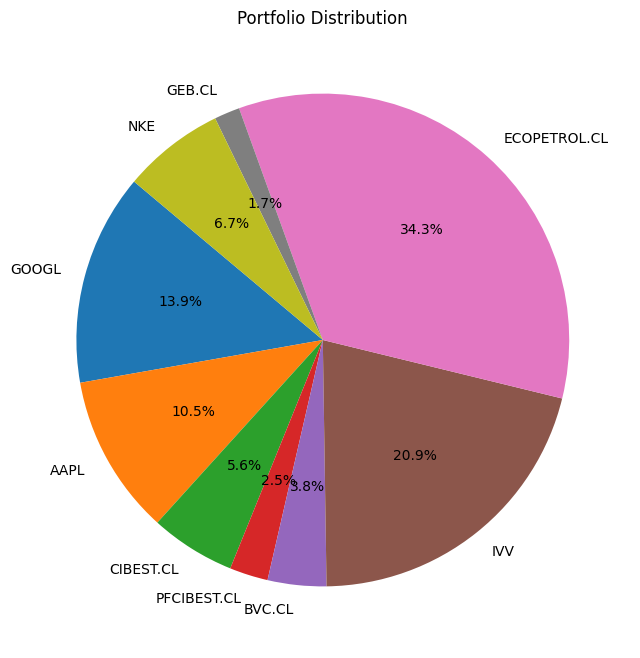

In [18]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

#Pie plot of portfolio distribution
plt.figure(figsize=(8,8))
plt.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Distribution')
plt.show()

In [20]:
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0,1))
ratios = ef.min_volatility()
cleaned_ratios = pd.Series(ratios)
cleaned_ratios.index = portfolio

optimal_portfolio = np.expand_dims(cleaned_ratios, axis=0)

# Rendimiento esperado
opt_portfolio_expected_return = np.matmul(optimal_portfolio, expected_stock_returns)

# Varianza del portafolio
opt_portfolio_var = np.matmul(optimal_portfolio, \
                              np.matmul(stock_returns_cov_matrix, optimal_portfolio.transpose()))

# Riesgo del portafolio
opt_portfolio_risk = math.sqrt(opt_portfolio_var)

# Ver datos obtenidos y Portafolio Óptimo de Markowitz:
print('PORTAFOLIO ÓPTIMO DE MARKOWITZ:')
print(f'Rendimiento esperado: {opt_portfolio_expected_return*100}')
print(f'Varianza del portafolio: {opt_portfolio_var*100}')
print(f'Riesgo del portafolio: {opt_portfolio_risk*100}')

print('\n\nDel 100% de tu capital, el modelo sugiere\
invertir las siguientes proporciones en cada activo:')
display(cleaned_ratios*100)
     


PORTAFOLIO ÓPTIMO DE MARKOWITZ:
Rendimiento esperado: [[0.06634499]]
Varianza del portafolio: [[0.00799033]]
Riesgo del portafolio: 0.8938863854003218


Del 100% de tu capital, el modelo sugiereinvertir las siguientes proporciones en cada activo:


C:\Users\jaayg\AppData\Local\Temp\ipykernel_11236\1680248768.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_portfolio_risk = math.sqrt(opt_portfolio_var)


ECOPETROL.CL     1.317784
GEB.CL          12.103881
PFCIBEST.CL      0.000000
CIBEST.CL       11.612843
GOOGL            0.000000
AAPL             0.000000
BVC.CL          14.485683
NKE              0.000000
IVV             60.479808
dtype: float64